,fold,widthi,depthi,best_dev_loss
name,,,,
24,0,[64],[2],0.266875
25,0,"[64, 128]","[2, 2]",0.260767
26,0,"[64, 128, 256]","[2, 2, 2]",0.265312
27,0,"[64, 128, 256, 512]","[2, 2, 2, 2]",0.261712
28,1,[64],[2],0.232143
29,1,"[64, 128]","[2, 2]",0.213559
30,1,"[64, 128, 256]","[2, 2, 2]",0.230232
31,1,"[64, 128, 256, 512]","[2, 2, 2, 2]",0.240057
32,2,[64],[2],0.242625


<Axes: xlabel='fold', ylabel='best_dev_loss'>

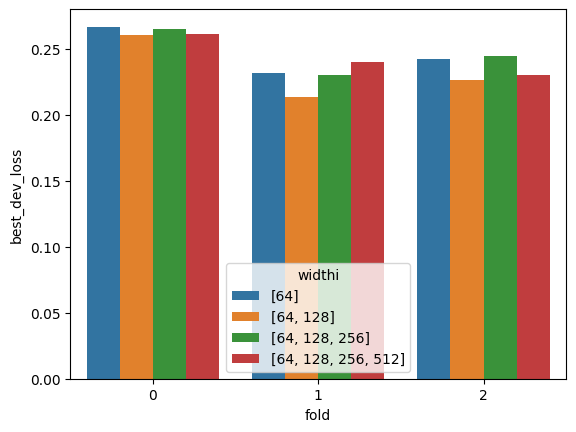

In [28]:
# TODO : dev set for sequenced dataloader
# TODO : dev set that's a mix of trianing set instead of held out
# TODO : understand torch generator
# TODO : implement torch generator for trianing
# TODO : could we define param groups, one for the encoder, and put a lower learning rate? 
# i noticed unfrozen training loss is volatile

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from lib.ekyn import *
from lib.env import *
import copy
from sage.utils import *

states = []
evals = []
# for model in range(1,5):
for model in range(24,36):
    MODEL_ID = f'{model}'

    state = torch.load(f'{TMP_EXPERIMENTS_PATH}/{MODEL_ID}/state.pt',map_location='cpu',weights_only=False)
    states.append(state)
    state['name'] = f'{model}'

df = pd.DataFrame(states).set_index(keys='name')[['fold','widthi','depthi','best_dev_loss']]
display(df)
df.widthi = df.widthi.astype(str)
sns.barplot(data=df,x='fold',y='best_dev_loss',hue='widthi')
# # display(pd.DataFrame(states).set_index(keys='name')[['sequence_length','bidirectional','fold','frozen_encoder']])

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,4.2))

colors = ['C0','C1','C2','C3','C4']
for i,state in enumerate(states):
    axes[0].plot(state['trainlossi'],color=colors[i],linestyle='-',label=state['name'])
    axes[0].plot(state['devlossi'],color=colors[i],linestyle=':')
    axes[0].plot(state['testlossi'],color=colors[i],linestyle='--')
    axes[0].axvline(state['best_dev_loss_epoch'],color=colors[i],linestyle=':',)
    axes[0].axhline(state['best_dev_loss'],color=colors[i],linestyle=':',)
    axes[0].axhline(state['testlossi'][state['best_dev_loss_epoch']],color=colors[i],linestyle='--')
plt.yscale('log')
axes[0].set_ylim([.15,.3])
axes[0].legend()
for i,state in enumerate(states):
    axes[1].plot(state['devf1i'],color=colors[i],linestyle=':')
    axes[1].plot(state['testf1i'],color=colors[i],linestyle='--')
    axes[1].axvline(state['best_dev_loss_epoch'],color=colors[i],linestyle=':')
    axes[1].axvline(torch.tensor(state['devf1i']).argmax(),color=colors[i],linestyle='--')
    axes[1].axhline(state['testf1i'][state['best_dev_loss_epoch']],color=colors[i],linestyle=':')
    axes[1].axhline(state['testf1i'][torch.tensor(state['devf1i']).argmax()],color=colors[i],linestyle='--')
# plt.yscale('log')
# plt.ylim([.85,.95])
# plt.savefig('out.jpg')

In [123]:
evals = []
for state in states:
    model = copy.deepcopy(state['model'])
    model.load_state_dict(state['best_model_wts_dev_loss'])
    trainloader,testloader = get_sequenced_dataloaders_loo(**state)
    evals.append(evaluate(dataloader=testloader,model=model,criterion=state['criterion'],device='cuda'))

train_ids ['F1-1', 'C1-0', 'A1-1', 'E1-0', 'A4-0', 'B1-0', 'E4-0', 'F1-0', 'C4-1', 'D1-0', 'B3-1', 'A1-0', 'C4-0', 'F5-1', 'E4-1']
test_ids ['E2-1']
train_ids ['F1-1', 'C1-0', 'A1-1', 'E1-0', 'A4-0', 'B1-0', 'E4-0', 'F1-0', 'C4-1', 'D1-0', 'B3-1', 'A1-0', 'C4-0', 'F5-1', 'E4-1']
test_ids ['E2-1']


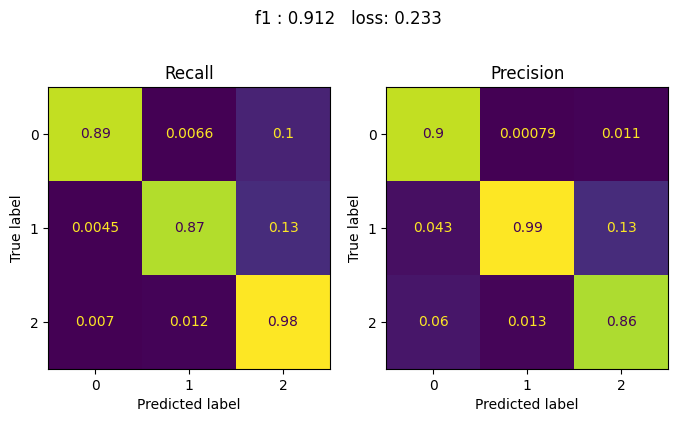

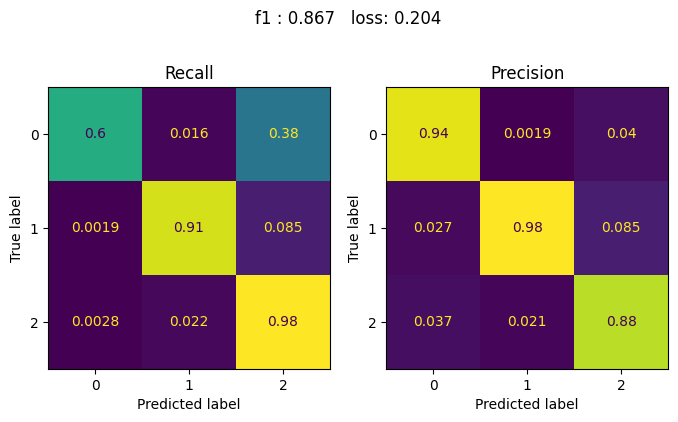

In [124]:
for loss,y_true,y_pred in evals:
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4.5))
    ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',colorbar=False,ax=axes[0])
    ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='pred',colorbar=False,ax=axes[1])
    axes[0].set_title('Recall')
    axes[1].set_title('Precision')
    plt.suptitle(f'f1 : {f1_score(y_true,y_pred,average="macro"):.3f}   loss: {loss:.3f}')

In [ ]:
# df = pd.DataFrame(states).reset_index()
# # df = df.melt(id_vars='index',value_vars=['best_dev_loss','best_test_loss'])
# df = df.melt(id_vars='index',value_vars=['best_dev_loss'])
# sns.barplot(data=df,x='index',y='value',hue='variable')

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay
# from lib.ekyn import *
# from lib.env import *
# import copy
# from sage.utils import *

# MODEL_ID = f'15'

# state = torch.load(f'{TMP_EXPERIMENTS_PATH}/{MODEL_ID}/state.pt',map_location='cpu',weights_only=False)
# model = copy.deepcopy(state['model'])
# model.load_state_dict(state['best_model_wts_dev_loss'])
# trainloader,testloader = get_sequenced_dataloaders_loo(**state)
# loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=state['criterion'],device='cuda')
# fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4.5))
# ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',colorbar=False,ax=axes[0])
# ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='pred',colorbar=False,ax=axes[1])
# axes[0].set_title('Recall')
# axes[1].set_title('Precision')
# plt.suptitle(f'f1 : {f1_score(y_true,y_pred,average="macro"):.3f}   loss: {loss:.3f}')
# print(state['criterion'].weight)
# # TODO : add best loss epoch during training
# plot_loss(state,f'{TMP_EXPERIMENTS_PATH}/{MODEL_ID}')